### 使用 PINN 解 Schrodinger 方程

Schrodinger 方程的形式为：
$$
i \frac{\partial h}{\partial t} = - \frac{1}{2} \frac{\partial^2 h}{\partial x^2} - |h|^2 h
$$

初始条件为：$h(0, x) = 2 \ {\rm sech} (x)$

边界条件为：$h(t, -5) = h(t, 5) = 0$ 和 $h_x(t, -5) = h_x(t, 5)$


In [59]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

In [60]:
# 选择设备
# GPU usage #########################################
# dtype = torch.FloatTensor # uncomment if you are using CPU
dtype = torch.cuda.FloatTensor # uncomment if you are using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 准备数据集

In [61]:
def schrodinger_eq(h, x, dx):
    # 计算空间导数
    h_x = np.gradient(h, dx)
    h_xx = np.gradient(h_x, dx)

    # 薛定谔方程
    f = 0.5j * h_xx + 1j * np.abs(h) ** 2 * h

    return f


# 四阶龙格 - 库塔方法
def rk4(h, x, dx, dt):
    k1 = schrodinger_eq(h, x, dx)
    k2 = schrodinger_eq(h + 0.5 * dt * k1, x, dx)
    k3 = schrodinger_eq(h + 0.5 * dt * k2, x, dx)
    k4 = schrodinger_eq(h + dt * k3, x, dx)

    h += (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    return h

In [62]:
# 参数设置
x_min = -5
x_max = 5
N_x = 256  # 空间离散点数
t_min = 0
t_max = np.pi / 2
N_t = int(1e4)  # 时间离散点数

# 空间网格
x = np.linspace(x_min, x_max, N_x)
dx = x[1] - x[0]
# 初始条件
h = 2 / np.cosh(x)
# 确保初始条件是复数类型
h = h.astype(np.complex128)

# 时间步长
dt = (t_max - t_min) / N_t

# 存储解
h_history = []
h_history.append(h.copy())

# 时间推进
for _ in range(N_t):
    rk4(h, x, dx, dt)
    h_history.append(h.copy())

In [63]:
h_history = np.asarray(h_history).T
abs_h = np.abs(h_history)

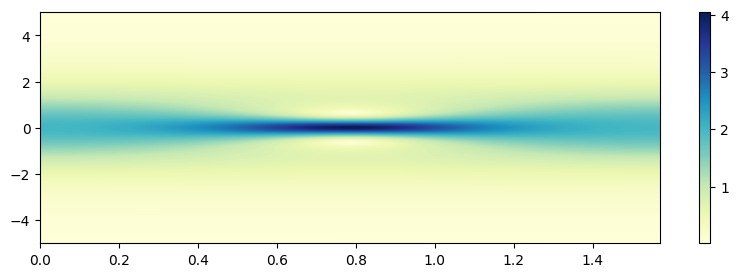

In [64]:
plt.figure(figsize=(10, 3))
im = plt.imshow(abs_h, extent=(t_min, t_max, x_min, x_max), origin='lower', aspect='auto', cmap='YlGnBu')
plt.colorbar(im)
plt.show()

#### 构建 PINN 模型

In [65]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 2)
        ).to(device)
    
    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        uv = self.net(xt)

        return uv

#### 定义约束条件

In [66]:
def f_uv(x, t, net):
    """
    pde = f_real + i*f_imag
    f_real = -(v_t - 0.5*u_xx - (u**2 + v**2) * u)
    f_imag = u_t + 0.5*v_xx + (u**2 + v**2) * v
    """
    uv = net(x, t)
    u = uv[:,0:1]
    v = uv[:,1:2]

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    f_real = v_t - 0.5*u_xx - (u**2 + v**2) * u
    f_imag = u_t + 0.5*v_xx + (u**2 + v**2) * v

    return f_real, f_imag

# 边界限制调条件
def boundary_condition(x_b, t_b, net):
    uv_b = net(x_b, t_b)
    u_b = uv_b[:,0:1]
    v_b = uv_b[:,1:2]
    u_b_x = torch.autograd.grad(u_b, x_b, grad_outputs=torch.ones_like(u_b), create_graph=True)[0]
    v_b_x = torch.autograd.grad(v_b, x_b, grad_outputs=torch.ones_like(v_b), create_graph=True)[0]

    return u_b, v_b, u_b_x, v_b_x
    

#### 准备训练数据

In [67]:
N0 = 50         # 初始边界取样点
N_b = 50        # 空间边界取样点
N_pde = 20000   # pde的取样点

# 参数设置
x_min = -5
x_max = 5
N_x = 256  # 空间离散点数
t_min = 0
t_max = np.pi / 2
N_t = int(1e6)  # 时间离散点数

# 生成随机的时间初始边界
x_0_x = np.random.uniform(x_min, x_max, (N0, 1))
t_0_x = np.zeros((N0, 1))
u_0_x = 2 / np.cosh(x_0_x)
v_0_x = np.zeros((N0, 1))

# 生成随机的空间边界
t_b = np.random.uniform(t_min, t_max, (N_b, 1))
x_b_upper = np.ones((N_b, 1)) * x_max
x_b_lower = np.ones((N_b, 1)) * x_min

# 生成随机的pde
t_pde = np.random.uniform(t_min, t_max, (N_pde, 1))
x_pde = np.random.uniform(x_min, x_max, (N_pde, 1))
all_pde = np.zeros((N_pde, 1))  

In [68]:
# 将所有数据转换为PyTorch张量，并加入到设备中
pt_x_0_x = torch.from_numpy(x_0_x).float().requires_grad_(True).to(device)
pt_t_0_x = torch.from_numpy(t_0_x).float().requires_grad_(True).to(device)
pt_u_0_x = torch.from_numpy(u_0_x).float().requires_grad_(True).to(device)
pt_v_0_x = torch.from_numpy(v_0_x).float().requires_grad_(True).to(device)

pt_t_b = torch.from_numpy(t_b).float().requires_grad_(True).to(device)
pt_x_b_upper = torch.from_numpy(x_b_upper).float().requires_grad_(True).to(device)
pt_x_b_lower = torch.from_numpy(x_b_lower).float().requires_grad_(True).to(device)

pt_t_pde = torch.from_numpy(t_pde).float().requires_grad_(True).to(device)
pt_x_pde = torch.from_numpy(x_pde).float().requires_grad_(True).to(device)
pt_all_pde = torch.from_numpy(all_pde).float().requires_grad_(True).to(device)

#### 构建PINN模型，损失函数 和 优化器

In [69]:
net = PINN()
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=15000, gamma=0.1)   # 每10000步学习率乘以0.1

#### 开始训练

In [70]:
net.train()
iterations = 50000

for epoch in range(iterations):
    optimizer.zero_grad()   # 将梯度信息清零

    uv = net(pt_x_0_x, pt_t_0_x)
    # 时间边界损失
    mse_0_x_u = mse_cost_function(uv[:,0:1], pt_u_0_x)
    mse_0_x_v = mse_cost_function(uv[:,1:2], pt_v_0_x)

    # 空间边界损失
    u_b_upper, v_b_upper, u_b_x_upper, v_b_x_upper = boundary_condition(pt_x_b_upper, pt_t_b, net)
    u_b_lower, v_b_lower, u_b_x_lower, v_b_x_lower = boundary_condition(pt_x_b_lower, pt_t_b, net)

    mse_u_b = mse_cost_function(u_b_upper, u_b_lower)
    mse_v_b = mse_cost_function(v_b_upper, v_b_lower)
    mse_u_b_x = mse_cost_function(u_b_x_upper, u_b_x_lower)
    mse_v_b_x = mse_cost_function(v_b_x_upper, v_b_x_lower)

    # pde损失
    f_real, f_imag = f_uv(pt_x_pde, pt_t_pde, net)
    mse_f = mse_cost_function(f_real, pt_all_pde) + mse_cost_function(f_imag, pt_all_pde)
    
    # 总损失
    loss = mse_0_x_u + mse_0_x_v + mse_u_b + mse_v_b + mse_u_b_x + mse_v_b_x + mse_f
    loss.backward() # 反向传播
    optimizer.step() # 更新参数
    scheduler.step()

    if epoch%1000 == 0:
    	print(epoch,"Traning Loss:",loss.item())

0 Traning Loss: 0.45951443910598755
1000 Traning Loss: 0.03555220365524292
2000 Traning Loss: 0.02403850480914116
3000 Traning Loss: 0.020352918654680252
4000 Traning Loss: 0.02116427570581436
5000 Traning Loss: 0.015157816931605339
6000 Traning Loss: 0.014588038437068462
7000 Traning Loss: 0.010939881205558777
8000 Traning Loss: 0.00920398160815239
9000 Traning Loss: 0.013679493218660355
10000 Traning Loss: 0.01633559539914131
11000 Traning Loss: 0.007004778832197189
12000 Traning Loss: 0.004275187384337187
13000 Traning Loss: 0.004067107103765011
14000 Traning Loss: 0.005504455417394638
15000 Traning Loss: 0.0029810345731675625
16000 Traning Loss: 0.002180715324357152
17000 Traning Loss: 0.0019782218150794506
18000 Traning Loss: 0.0016994541510939598
19000 Traning Loss: 0.0013318920973688364
20000 Traning Loss: 0.0010240518022328615
21000 Traning Loss: 0.00112035998608917
22000 Traning Loss: 0.0006201110081747174
23000 Traning Loss: 0.0004926847759634256
24000 Traning Loss: 0.0004066

#### 第二次训练

In [74]:
for epoch in range(iterations):
    optimizer.zero_grad()   # 将梯度信息清零

    uv = net(pt_x_0_x, pt_t_0_x)
    # 时间边界损失
    mse_0_x_u = mse_cost_function(uv[:,0:1], pt_u_0_x)
    mse_0_x_v = mse_cost_function(uv[:,1:2], pt_v_0_x)

    # 空间边界损失
    u_b_upper, v_b_upper, u_b_x_upper, v_b_x_upper = boundary_condition(pt_x_b_upper, pt_t_b, net)
    u_b_lower, v_b_lower, u_b_x_lower, v_b_x_lower = boundary_condition(pt_x_b_lower, pt_t_b, net)

    mse_u_b = mse_cost_function(u_b_upper, u_b_lower)
    mse_v_b = mse_cost_function(v_b_upper, v_b_lower)
    mse_u_b_x = mse_cost_function(u_b_x_upper, u_b_x_lower)
    mse_v_b_x = mse_cost_function(v_b_x_upper, v_b_x_lower)

    # pde损失
    f_real, f_imag = f_uv(pt_x_pde, pt_t_pde, net)
    mse_f = mse_cost_function(f_real, pt_all_pde) + mse_cost_function(f_imag, pt_all_pde)
    
    # 总损失
    loss = mse_0_x_u + mse_0_x_v + mse_u_b + mse_v_b + mse_u_b_x + mse_v_b_x + mse_f
    loss.backward() # 反向传播
    optimizer.step() # 更新参数
    scheduler.step()

    if epoch%1000 == 0:
    	print(epoch,"Traning Loss:",loss.item())

0 Traning Loss: 5.4295571317197755e-05
1000 Traning Loss: 5.168587085790932e-05
2000 Traning Loss: 4.929241549689323e-05
3000 Traning Loss: 4.7141893446678296e-05
4000 Traning Loss: 4.5076470996718854e-05
5000 Traning Loss: 4.3232190364506096e-05
6000 Traning Loss: 4.1496001358609647e-05
7000 Traning Loss: 3.99099153582938e-05
8000 Traning Loss: 3.8446079997811466e-05
9000 Traning Loss: 3.7016226997366175e-05
10000 Traning Loss: 3.571672277757898e-05
11000 Traning Loss: 3.555987132131122e-05
12000 Traning Loss: 3.5315388231538236e-05
13000 Traning Loss: 3.49531983374618e-05
14000 Traning Loss: 3.4444801713107154e-05
15000 Traning Loss: 3.37860437866766e-05
16000 Traning Loss: 3.309964085929096e-05
17000 Traning Loss: 3.244004983571358e-05
18000 Traning Loss: 3.1801559089217335e-05
19000 Traning Loss: 3.1184063118416816e-05
20000 Traning Loss: 3.0586859793402255e-05
21000 Traning Loss: 3.000945071107708e-05
22000 Traning Loss: 2.9450726287905127e-05
23000 Traning Loss: 2.891014992201235

In [75]:
# 空间网格
# 参数设置
x_min = -5
x_max = 5
N_x = 256  # 空间离散点数
t_min = 0
t_max = np.pi / 2
N_t = int(1e4)  # 时间离散点数
x_pred = np.linspace(x_min, x_max, N_x)
t_pred = np.linspace(t_min, t_max, N_t)
ms_x, ms_t = np.meshgrid(x_pred, t_pred)

x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = torch.from_numpy(x).float().to(device)
pt_t = torch.from_numpy(t).float().to(device)

pt_uv = net(pt_x, pt_t)

uv = pt_uv.data.cpu().numpy()
u = uv[:,0].reshape(ms_x.shape)
v = uv[:,1].reshape(ms_x.shape)
h = np.sqrt(u**2 + v**2).T

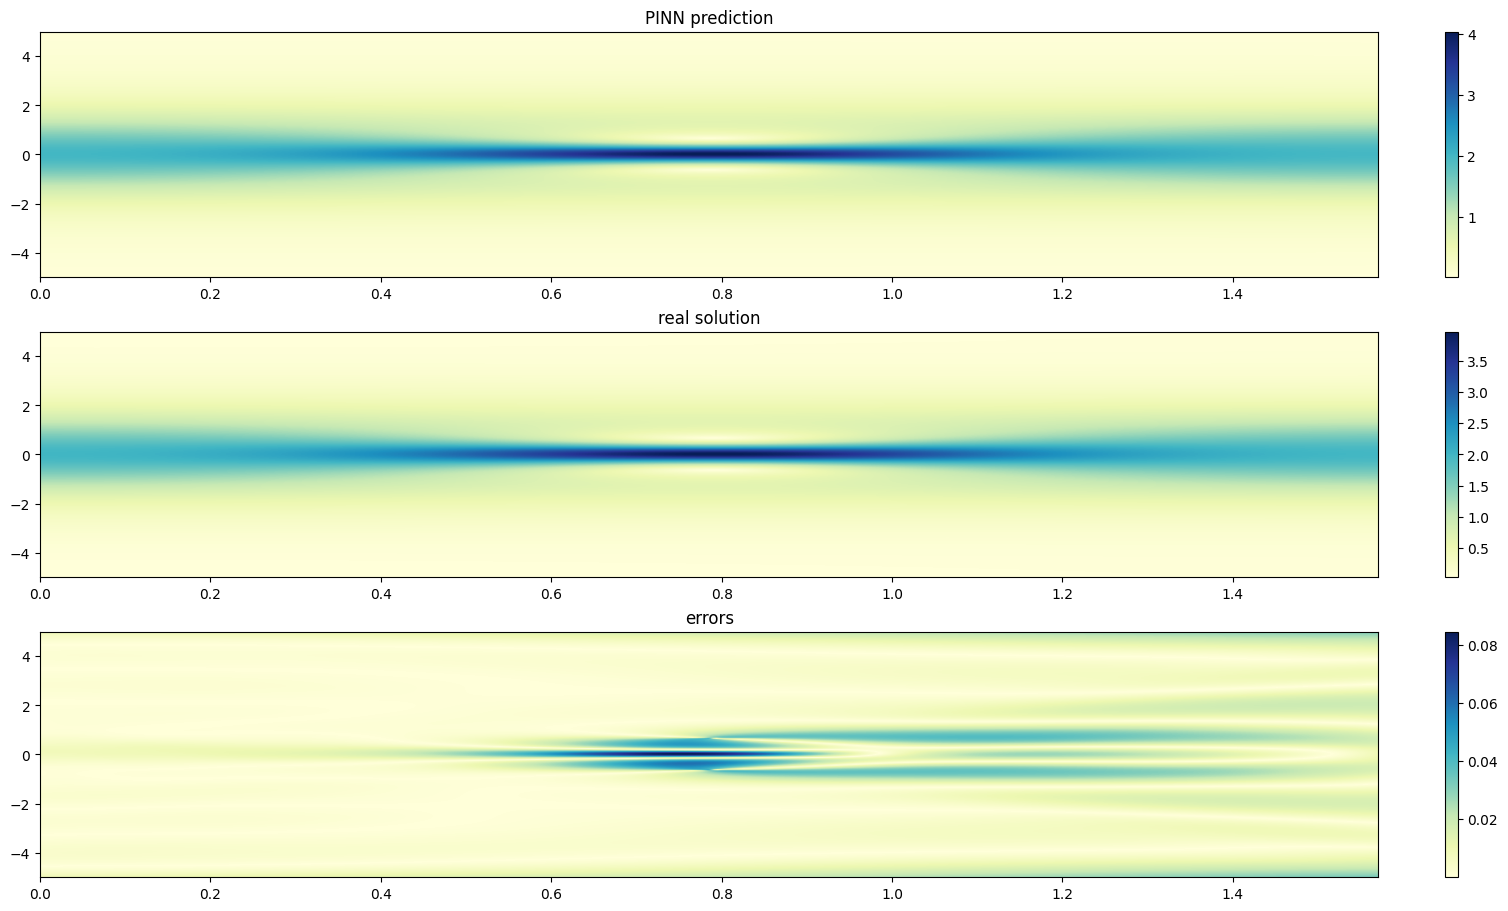

In [76]:
fig, axs = plt.subplots(3, 1, figsize=(15, 9), layout='constrained')
im = axs[0].imshow(abs_h[:, :-1], extent=(t_min, t_max, x_min, x_max), origin='lower', aspect='auto', cmap='YlGnBu')
plt.colorbar(im)
axs[0].set_title('PINN prediction')

im = axs[1].imshow(h, extent=(t_min, t_max, x_min, x_max), origin='lower', aspect='auto', cmap='YlGnBu')
plt.colorbar(im)
axs[1].set_title('real solution')

im = axs[2].imshow(np.abs(abs_h[:, :-1]-h), extent=(t_min, t_max, x_min, x_max), origin='lower', aspect='auto', cmap='YlGnBu')
plt.colorbar(im)
axs[2].set_title('errors')

plt.show()

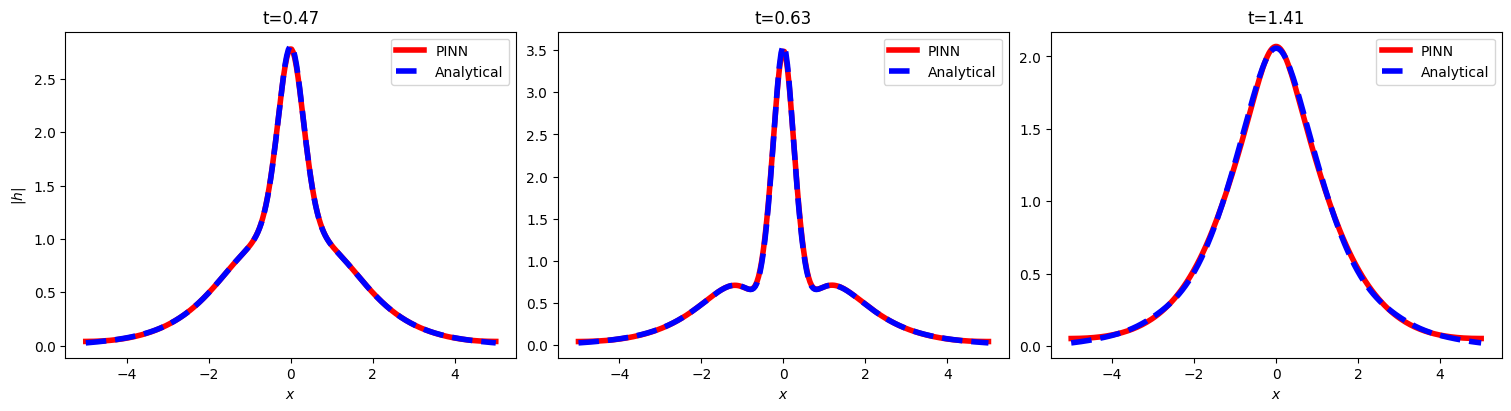

In [101]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), layout='constrained')

axs[0].plot(x_pred, h[:, 3000], label='PINN', color='r', linewidth=4)
axs[0].plot(x_pred, abs_h[:, 3000], label='Analytical', color='b', linestyle='--', linewidth=4)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$|h|$')
axs[0].set_title(f't={t_pred[3000]:.2f}')
axs[0].legend()

axs[1].plot(x_pred, h[:, 4000], label='PINN', color='r', linewidth=4)
axs[1].plot(x_pred, abs_h[:, 4000], label='Analytical', color='b', linestyle='--', linewidth=4)
axs[1].set_xlabel('$x$')
# axs[1].set_ylabel('$|h|$')
axs[1].set_title(f't={t_pred[4000]:.2f}')
axs[1].legend()

axs[2].plot(x_pred, h[:, 9000], label='PINN', color='r', linewidth=4)
axs[2].plot(x_pred, abs_h[:, 9000], label='Analytical', color='b', linestyle='--', linewidth=4)
axs[2].set_xlabel('$x$')
# axs[2].set_ylabel('$|h|$')
axs[2].set_title(f't={t_pred[9000]:.2f}')
axs[2].legend()

plt.show()